In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI_sigma import IVI

from tqdm import trange

import timeit

In [3]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5



#optimizer
learning_rate=0.005

#scheduler
patience=25
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=5000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

# Setup #

In [78]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='boston' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

#sigma_noise=setup.sigma_noise
print(setup.sigma_noise)

sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
print(size_data)
#batch_size
batch_size=50#int(np.min([size_data/6,500]))
if dataset=='powerplant':
    batch_size=50

n_samples_FU=200 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0#batch_size#30 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

2.5
455


# Predictive model #

In [79]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

param_count

751

# ELBO

## Average Log Likelihood

In [80]:
#average log likelihood loss 
###!!!!!!! TODO
def loss(x_data, y_data, GeN,sigma_noise):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise).sum(dim=1)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [81]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
    epsilon=0.1
    M = x_train.max(0, keepdim=True)[0]+epsilon
    m = x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj


#prior on parameters of predictive model

def prior(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)


def kl(x_data, GeN, beta):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device, beta=beta)
    return K

def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [82]:
#ELBO
 #KL regularizer
    
def ELBO(x_data, y_data, GeN, sigma_noise):
    alpha=1.#(len(x_data)/size_data)
    beta=1. #TO DO
    Average_LogLikelihood=loss(x_data, y_data, GeN, sigma_noise)
    the_KL=kl(x_data, GeN, beta)
    the_ELBO= - Average_LogLikelihood+ alpha* the_KL#(len(x_data)/size_data)*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [83]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=751, bias=True)
  )
)


In [89]:
sigma_noise=torch.tensor(2.3)
_sigma_noise=torch.log(torch.exp(sigma_noise)-1).clone().to(device).detach().requires_grad_(False)
optimizer_noise=torch.optim.Adam([_sigma_noise],lr=0.05)
sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)
sigma_noise

tensor(2.3000, device='cuda:0')

# Optimizer

In [90]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer,optimizer_noise)

# Scheduler #

In [91]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [92]:
KLs=[]
ELBOs=[]
LRs=[]
LLs=[]
SIGMAs=[]
test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'KL_train':[],
              'HMC_OOD':[],
              'HMC_train':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:

        theta=GeN(1000).detach()
        sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

        metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise.detach().cpu(), std_y_train, device='cpu', std=False)
        metrics.update({'KL_train': kl_train(GeN,x_train[:500]).item()})
        metrics.update({'HMC_OOD': kl_HMC_OOD(GeN).item()})
        metrics.update({'HMC_train': kl_HMC_train(GeN,x_train[:500]).item()})
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN,_sigma_noise)
        
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'], sigma= scores['sigma'])

        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        SIGMAs.append(scores['sigma'])

        
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



  0%|          | 16/5000 [00:04<21:27,  3.87it/s, ELBO=57.5, KL=-30.4, LogLike=-87.9, lr=0.005, sigma=2.3]


KeyboardInterrupt: 

# Results on test #

In [ ]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
sigma_noise = torch.log(torch.exp(_sigma_noise.detach()) + 1.)
print('sigma_noise: '+str(sigma_noise))
metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise.cpu(), std_y_train, device='cpu')
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})
print(std_y_train)
print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

# PAC Bayes risks #

Given a distribution $Q$ of predictors, a distribution $D$ of data and a loss $L$, the risk of a predictor $f$ is 
$$ R(f)= E_{(x,y)\sim D}[l(f(x),y)] $$
The Bayes classifier (mean/majority vote) corresponding to $Q$ is given by
$$
f_Q(x)= E_{f\sim Q}[f(x)].
$$
The Gibbs predictor is stochastic and its risk is:
$$
R(g_Q)=E_{f\sim Q}R(f)=E_{f\sim Q}E_{(x,y)\sim D}[l(f(x),y)] 
$$
We want to find $Q$ that minimizes:
$$
R(f_Q)=E_{(x,y)\sim D}[l(E_{f\sim Q}[f(x)],y)]
$$
but also

In [106]:
n_predictors=1000
theta=GeN(n_predictors).detach()
pred=model(x_test,theta)
pred_=pred#+sigma_noise*torch.randn_like(pred)

marginal_se=(pred_-y_test)**2
empirical_sqloss=marginal_se.mean()
print('Empirical square loss on test: {:.4f}'.format(empirical_sqloss.item()))

Empirical square loss on test: 8.5483


In [107]:
n_predictors=1000
theta=GeN(n_predictors).detach()
pred=model(x_test,theta)
pred_=pred+sigma_noise*torch.randn_like(pred)
print((pred-y_test).mean(0).abs().mean())
print((pred_-y_test).mean(0).abs().mean())

tensor(0.2270, device='cuda:0')
tensor(0.2276, device='cuda:0')


In [108]:
#compute metrics on test

results={}
log_device='cpu'
theta=prior(2000).detach()
metrics_=evaluate_metrics(theta, model, x_test, y_test, sigma_noise.cpu(), std_y_train, device='cpu')
results.update({dataset:metrics_})

print(dataset)
print("prior's scores")
for m, r in metrics_.items():
    print(m+': '+str(r))

boston
prior's scores
RMSE: (7.03052282333374, 9.410202980041504)
LPP: (-3.672666072845459, 0.3362770974636078)
PICP: 1.0
MPIW: 605.640869140625


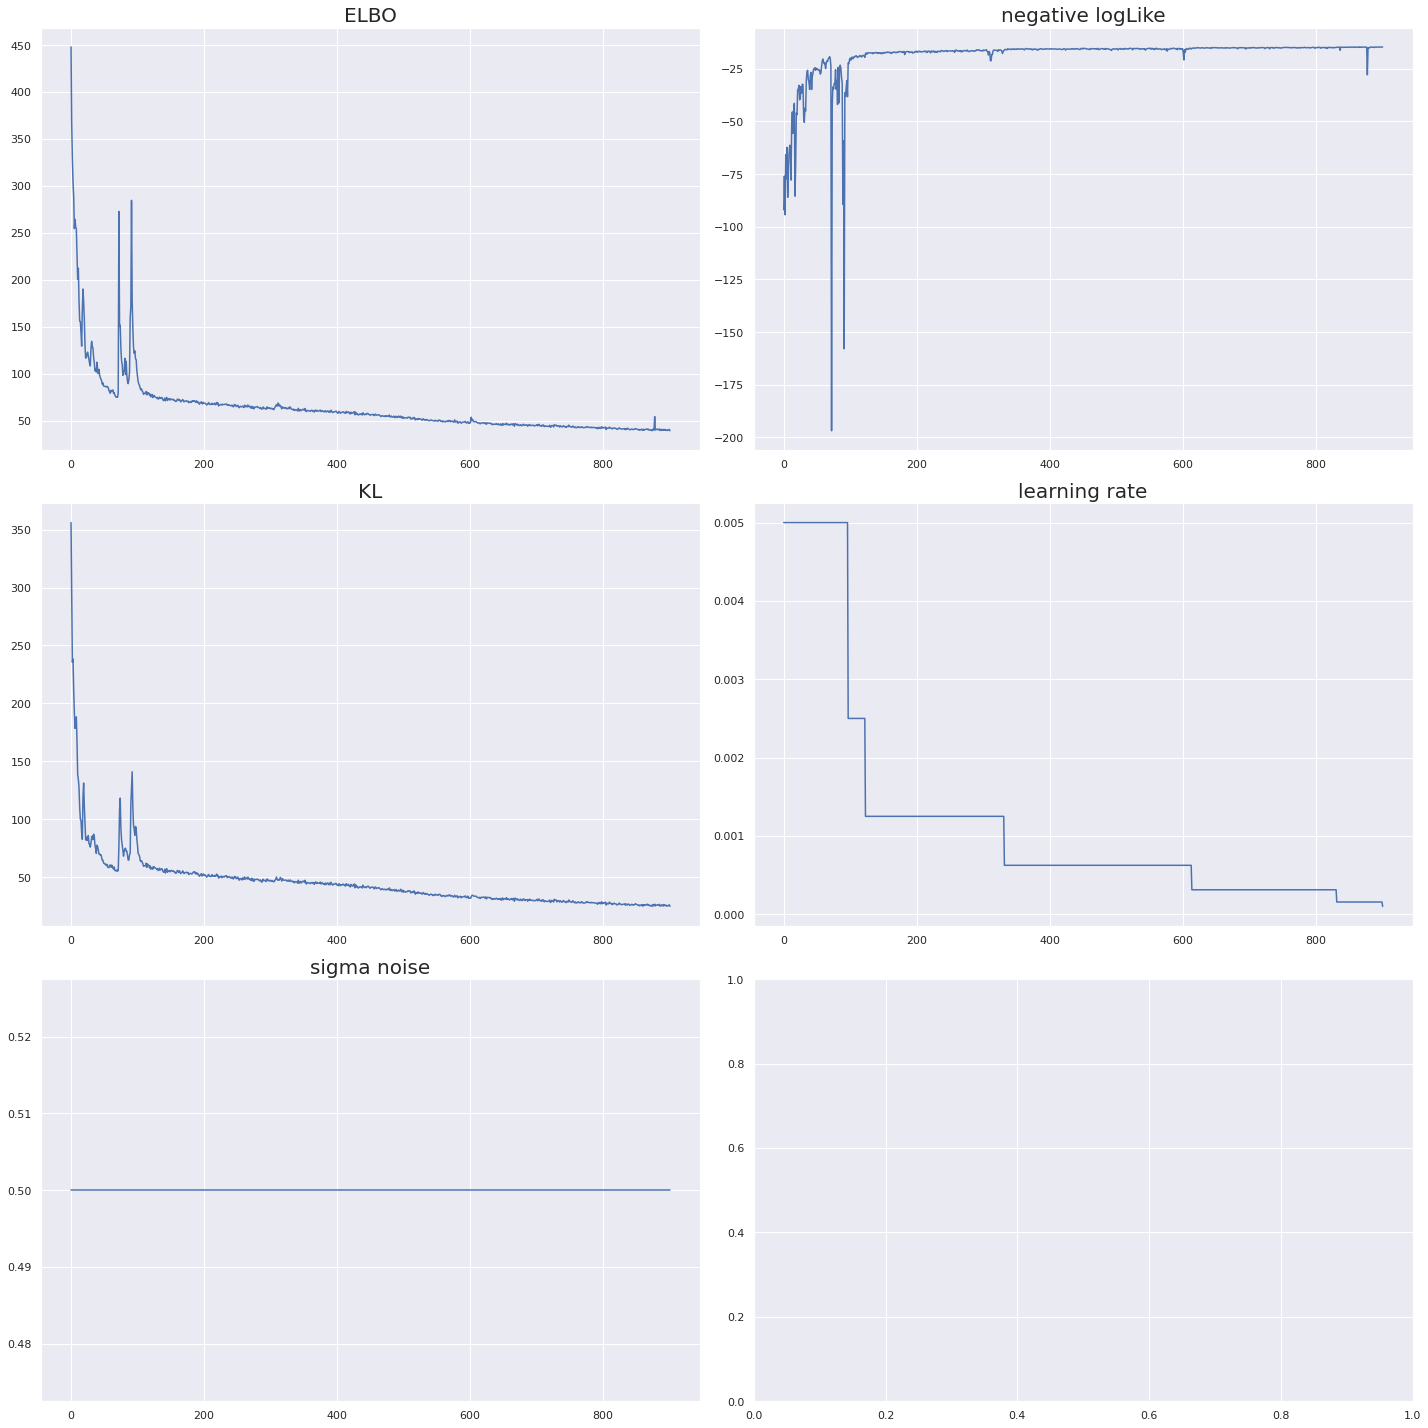

In [109]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs, 'SIGMA':SIGMAs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LL_=torch.as_tensor(training['LL'])
LR_=torch.as_tensor(training['LR'])
SIGMA_=torch.as_tensor(training['SIGMA'])

fig, ax =plt.subplots(3,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
ax[2,0].plot(time_line,SIGMA_)
ax[2,0].set_title('sigma noise', fontsize=20)
fig.tight_layout()

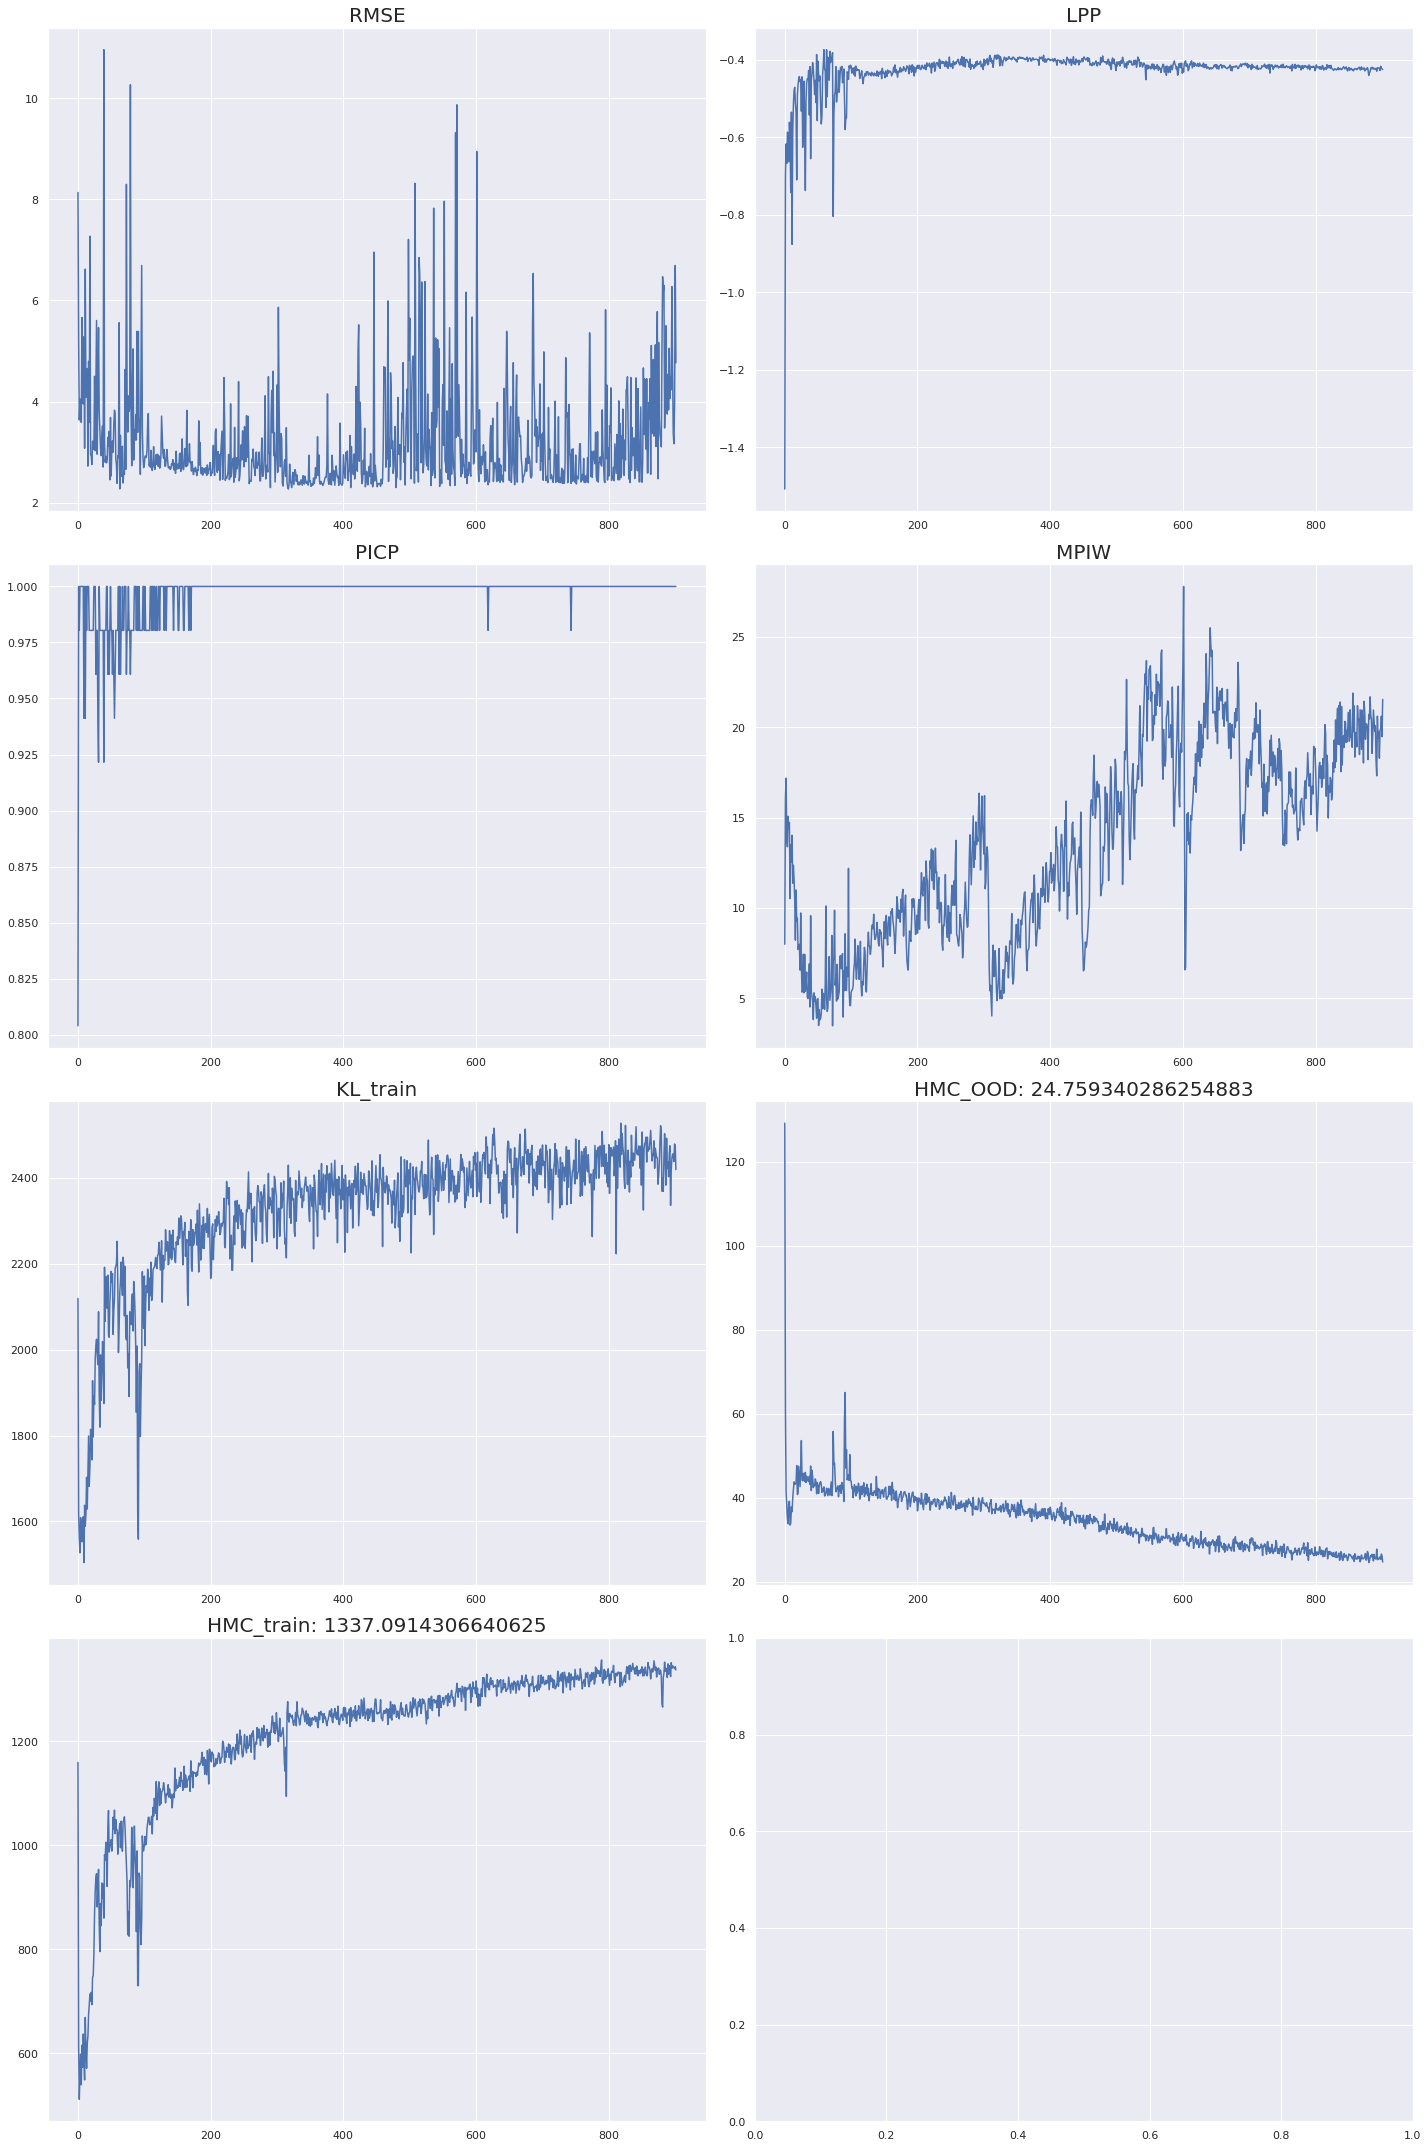

In [110]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(4,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
m='KL_train'
ax[2,0].plot(time_line,test_metrics[m])
ax[2,0].set_title(m, fontsize=20)
m='HMC_OOD'
ax[2,1].plot(time_line,test_metrics[m])
ax[2,1].set_title(m+': '+str(test_metrics[m][-1].item()), fontsize=20)
m='HMC_train'
ax[3,0].plot(time_line,test_metrics[m])
ax[3,0].set_title(m+': '+str(test_metrics[m][-1].item()), fontsize=20)

fig.tight_layout()

# posterior predictive diagnostic #

Text(0.5, 0.98, 'On train')

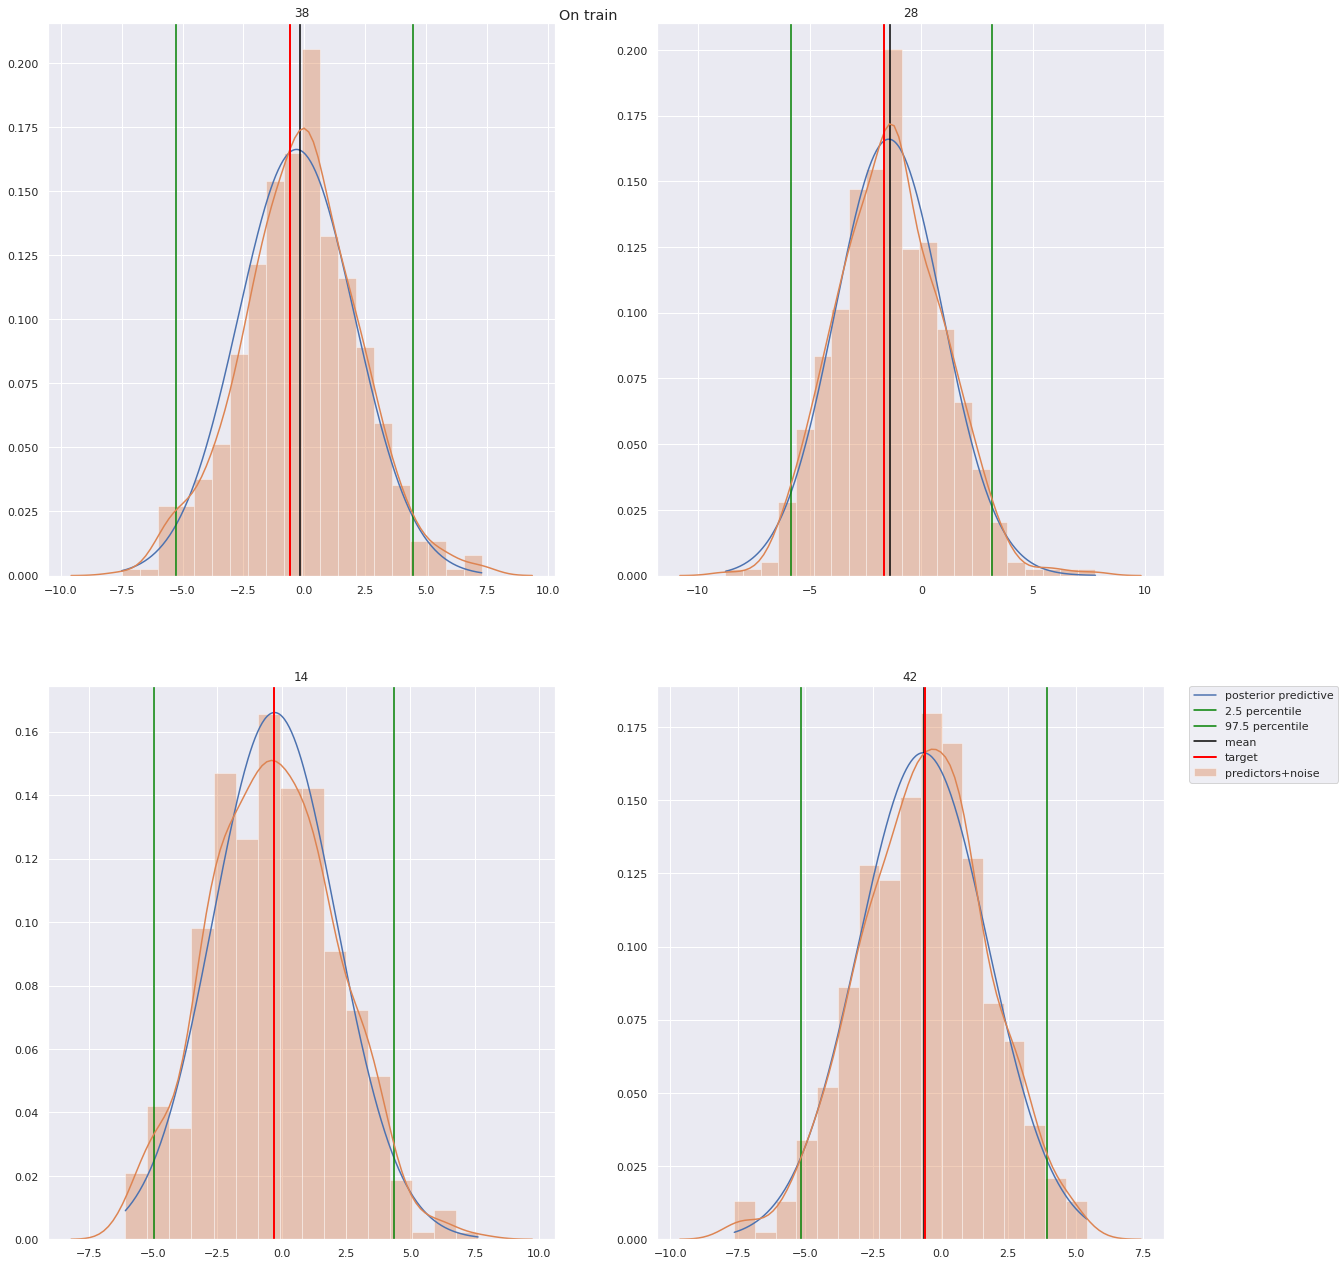

In [74]:
import seaborn as sns
from pylab import *
from Tools import log_norm

n_predictors=500
theta=GeN(n_predictors).detach()
pred=model(x_train,theta)
pred_=pred+sigma_noise*torch.randn_like(pred)

M = pred_.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)

y_pred_s, _ = pred_.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)

y_min = y_pred_s[0, :].squeeze().to(device)
y_max = y_pred_s[-1, :].squeeze().to(device)

lin_y=torch.linspace(0.,1.,300).unsqueeze(0).to(device)*(y_max-y_min).unsqueeze(-1)+y_min.unsqueeze(-1)



NLL=log_norm(lin_y.unsqueeze(-1),pred,sigma_noise*torch.ones(pred.shape[0], device=device))

n_predictor = torch.tensor(pred.shape[0], device=device).float()
LPP = NLL.logsumexp(dim=0) - torch.log(n_predictor)
LPP=LPP
LPP.shape


sns_plot=sns.set(rc={"figure.figsize": (20, 20)}, )
N=2
M=2
np.random.seed(42)

for _ in range(0,N*M):
    i=np.random.randint(0,y_test.shape[0])
    subplot(N,M,_+1)
    plt.plot(lin_y.view(-1,300)[i].squeeze().cpu(),LPP[i].exp().cpu(), label='posterior predictive')

    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred_.mean(0)[i].cpu(), color='black', label='mean')
#    ax=sns.distplot(pred_prior[:,i], label='prior')
#    ax =sns.distplot(pred[:,i].cpu(),label='predictors')
    ax =sns.distplot(pred_[:,i].cpu(),label='predictors+noise')
    line1=plt.axvline(y_train[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='On train')



Text(0.5, 0.98, 'On test (sigma_noise=2.40, RMSE on test=3.72, LPP on test=-1.82)')

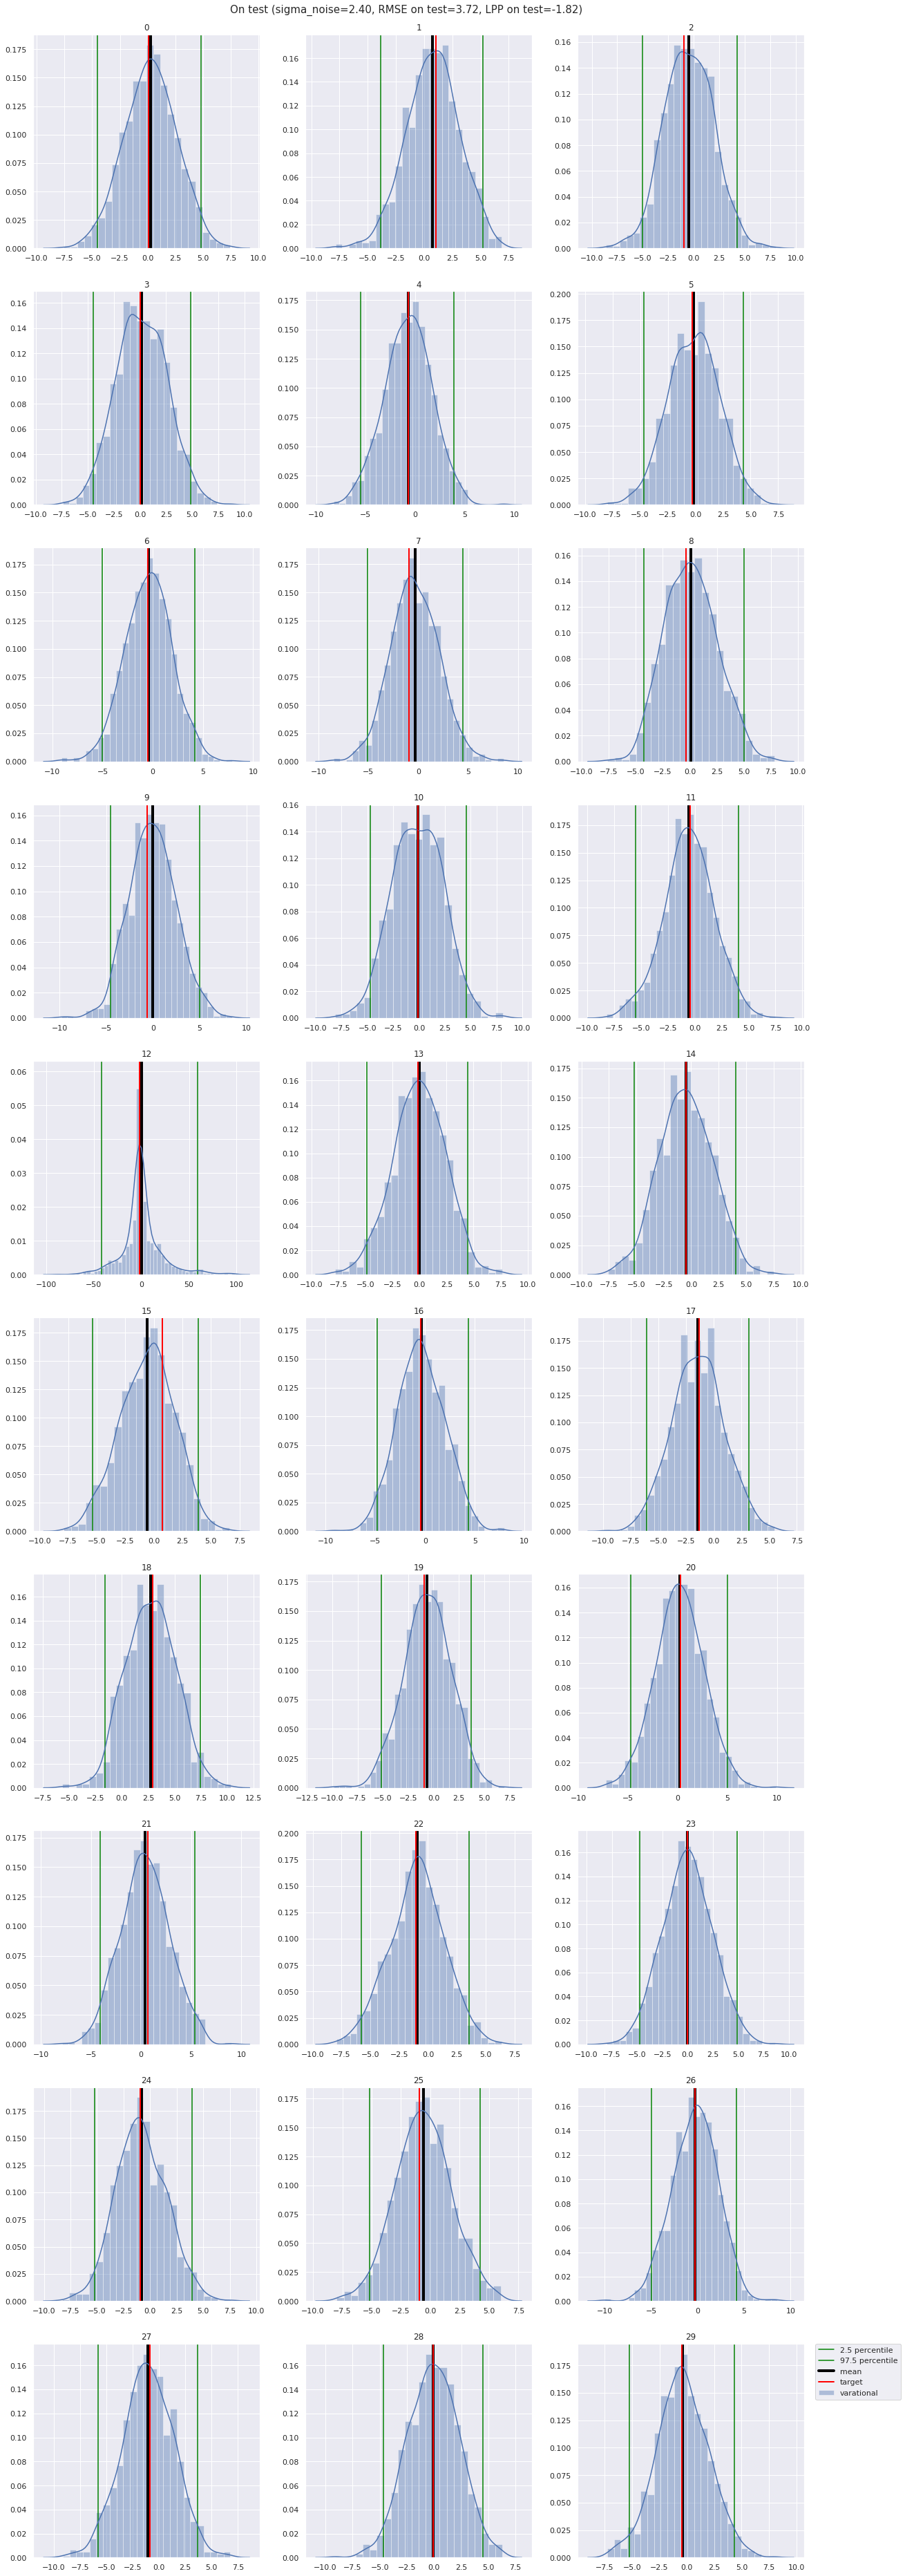

In [75]:
import seaborn as sns
from pylab import *

theta=GeN(1000).detach()
pred=model(x_test,theta)

pred_=pred+sigma_noise*torch.randn_like(pred)

M = pred.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)

y_pred_s, _ = pred_.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)

y_min = y_pred_s[0, :].squeeze().to(device)
y_max = y_pred_s[-1, :].squeeze().to(device)

lin_y=torch.linspace(0.,1.,300).unsqueeze(0).to(device)*2*(y_max-y_min).unsqueeze(-1)+(pred_.mean(0).squeeze()-2*(pred_.mean(0).squeeze()-y_min)).unsqueeze(-1)

NLL=log_norm(lin_y.unsqueeze(-1),pred,sigma_noise*torch.ones(pred.shape[0], device=device))

n_predictor = torch.tensor(pred.shape[0], device=device).float()
LPP = NLL.logsumexp(dim=0) - torch.log(n_predictor)


sns_plot=sns.set(rc={"figure.figsize": (20, 60)})
N=10
M=3
#np.random.seed(42)

for _ in range(1,1+N*M):
    i=_-1#np.random.randint(0,y_test.shape[0])
    subplot(N,M,_)
#    plt.plot(lin_y.view(-1,300)[i].squeeze().cpu(),LPP[i].exp().cpu(), label='posterior predictive')

    line2=plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    line3=plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred_.mean(0)[i].cpu(), color='black', lw=4.,label='mean')
 #   ax =sns.distplot(pred[:,i].cpu(),label='predictors')
    line5 =ax=sns.distplot(pred_[:,i].cpu(),label='varational')
    line1=plt.axvline(y_test[i].cpu(), color='red', linewidth=2.,label='target')


    plt.title(str(i))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(top=.97)
plt.suptitle(t='On test (sigma_noise={:.2f}, RMSE on test={:.2f}, LPP on test={:.2f})'.format(sigma_noise.item(),metrics['RMSE'][0],metrics['LPP'][0]),fontsize=15)


prior meanNN: 1.0508129596710205
variational meanNN: 1.7632534503936768
torch.Size([2000, 9, 300, 1])


Text(0.5, 0.98, 'out of distribution')

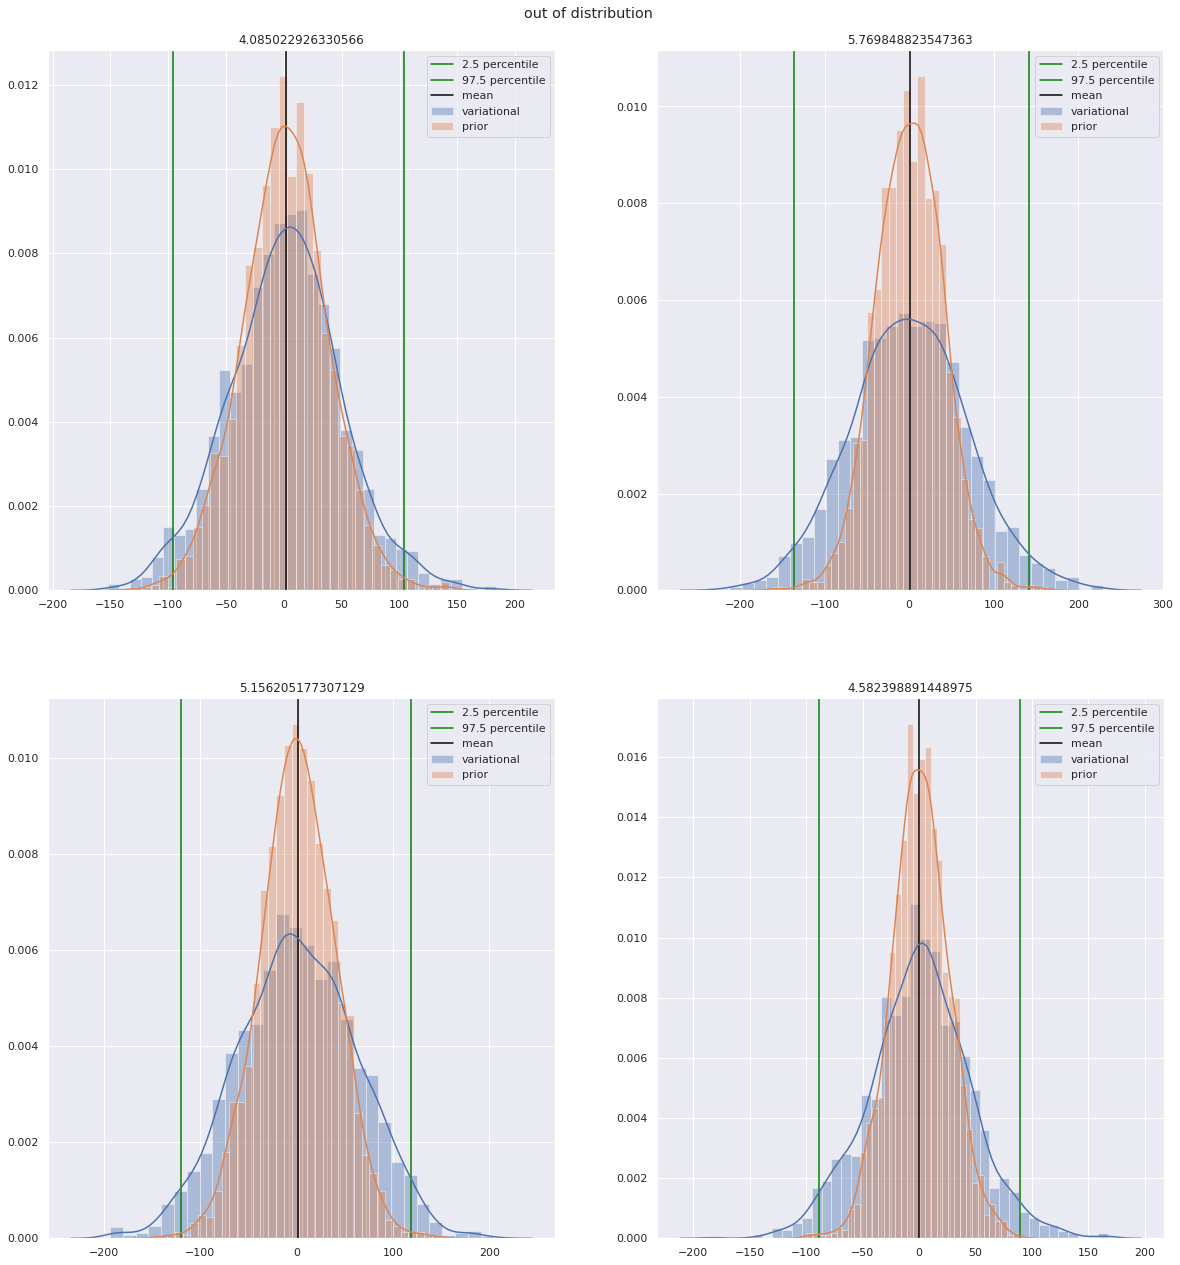

In [76]:
import seaborn as sns
from pylab import *
torch.manual_seed(seed=43) 

def meanlogKNNdistance(sample,k):
    distances= torch.cdist(sample, sample, p=2)
    kNN = torch.topk(distances, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf
    return kNN.log().mean()


theta=GeN(2000).detach()
epsilon=0.1
n_ood=9
M = x_train.max(0, keepdim=True)[0]+epsilon
m = x_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
pred=model(X_ood,theta)
pred_=pred+sigma_noise*torch.randn_like(pred)


theta_prior=prior(2000)
pred_prior=model(X_ood,theta_prior).cpu()
pred_HMC=model(X_ood,HMC).cpu()

print('prior meanNN: '+str(meanlogKNNdistance(pred_prior,k=1).item()))
print('variational meanNN: '+str(meanlogKNNdistance(pred,k=1).item()))

M = pred_.shape[0]
M_low = int(0.025 * M)
M_high = int(0.975 * M)


y_pred_s, _ = pred.sort(dim=0)

y_low = y_pred_s[M_low, :].squeeze().to(device)
y_high = y_pred_s[M_high, :].squeeze().to(device)


y_min = y_pred_s[0, :].squeeze().to(device)
y_max = y_pred_s[-1, :].squeeze().to(device)

lin_y=torch.linspace(0.,1.,300).unsqueeze(0).to(device)*(y_max-y_min).unsqueeze(-1)+y_min.unsqueeze(-1)

NLL=log_norm(lin_y.unsqueeze(-1),pred,sigma_noise*torch.ones(pred.shape[0], device=device))
print(NLL.shape)

n_predictor = torch.tensor(pred.shape[0], device=device).float()
LPP = NLL.logsumexp(dim=0) - torch.log(n_predictor)


sns.set(rc={"figure.figsize": (20, 20)})
N=2
np.random.seed(42)
for i in range(N**2):
    subplot(N,N,i+1)
#    plt.plot(lin_y.view(-1,300)[i].squeeze().cpu(),LPP[i].exp().cpu(), label='posterior predictive')

    plt.axvline(y_low[i].cpu(), color='green', label='2.5 percentile')
    plt.axvline(y_high[i].cpu(), color='green', label='97.5 percentile')
    line4=plt.axvline(pred.mean(0)[i].cpu(), color='black', label='mean')
    
    plt.title(str(torch.cdist(X_ood[i].unsqueeze(0), x_train).min().item()))
    ax=sns.distplot(pred_[:,i].cpu(), label='variational')
    ax=sns.distplot(pred_prior[:,i], label='prior')
 #   ax=sns.distplot(pred_HMC[:,i], label='HMC')

    plt.legend()
plt.subplots_adjust(top=.95)
plt.suptitle(t='out of distribution')

# Uncertainty vs Error #

Text(0.5, 0, 'Uncertainty (Diff Entropy)')

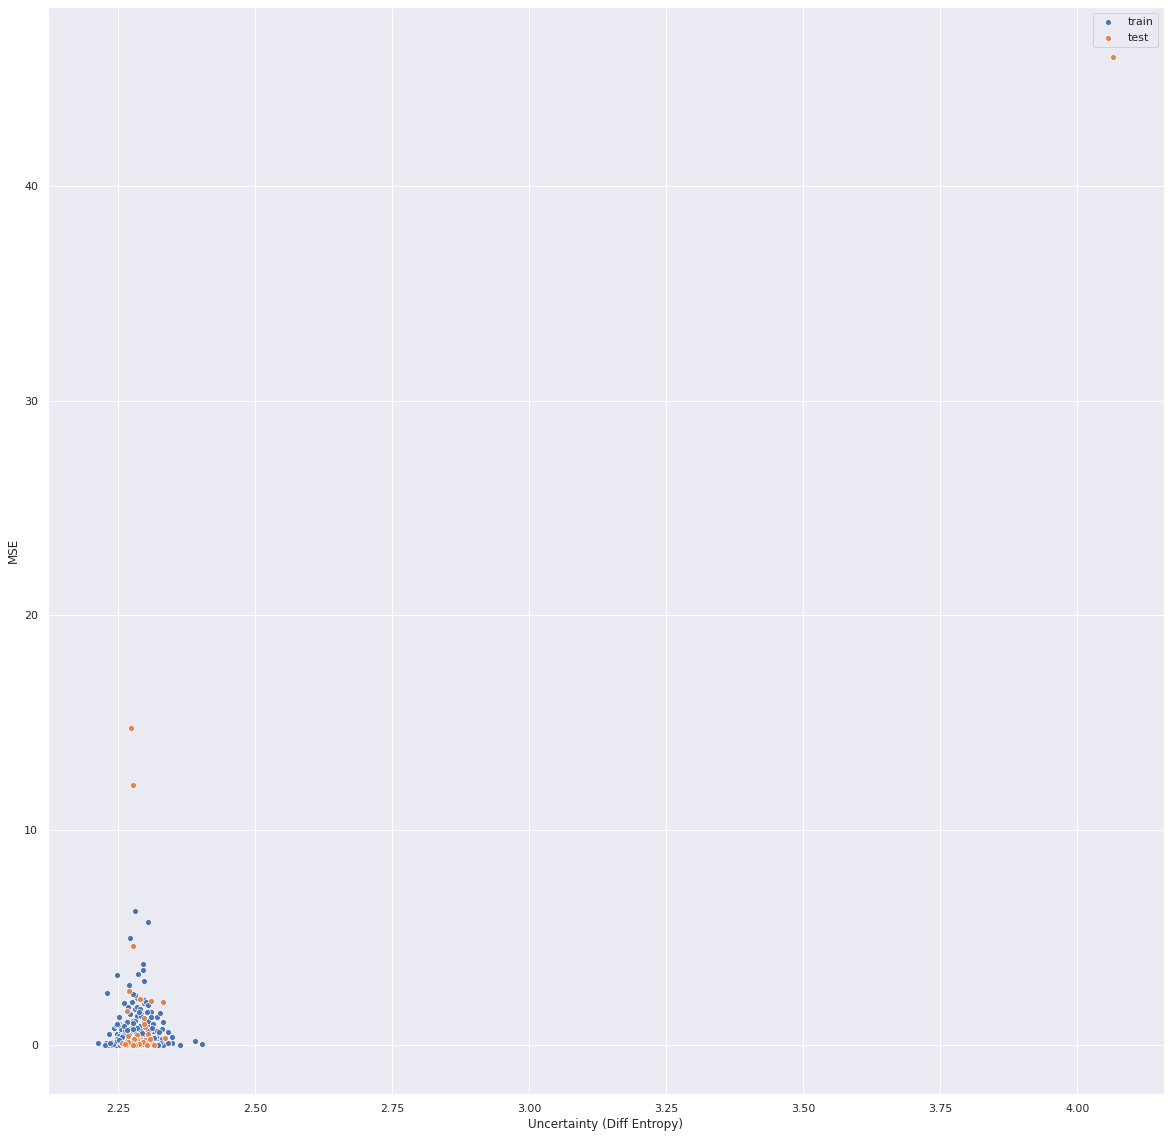

In [77]:
X=[x_train,x_test]
y=[y_train,y_test]
label=['train', 'test']
def Entropy(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x NbExemples X NbDimensions
        k (Int): ordinal number

    Returns:
        Tensor: H of size Batch x 1, k-Nearest Neighbour Estimation of the entropy of theta, H[b]=H(theta[b]).

    """
    batch=theta.shape[0]
    nb_samples=theta.shape[1]
    d=torch.tensor(theta.shape[-1]).float()
    D=torch.cdist(theta,theta)
    a = torch.topk(D, k=k+1, dim=1, largest=False, sorted=True)[0][:,k].to(device) #.clamp(torch.finfo().eps,float('inf'))    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    K_MC=torch.as_tensor(float(k_MC), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*torch.log(a).sum(1)



for i in range(len(X)):
    theta=GeN(1000).detach()
    pred_=model(X[i],theta)
    pred=pred_+sigma_noise*torch.randn_like(pred_)

    M = pred.shape[0]
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred_.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))


    H=(Entropy(pred.transpose(0,1),k=20))
    STD=(pred.std(0).squeeze())
    pred=model(X[i],theta)
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    ax=sns.scatterplot(H.cpu(),MSE.cpu(), label=label[i])
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')

(3.7, 4.2)

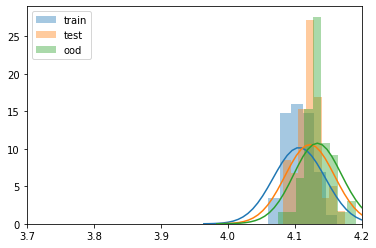

In [73]:
theta=GeN(500).detach()
epsilon=0.1
n_ood=2000
M = x_train.max(0, keepdim=True)[0]+epsilon
m = x_train.min(0, keepdim=True)[0]-epsilon
X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m  
X=[x_train,x_test,X_ood]
label=['train','test','ood']
for i in range(len(X)):
    pred=model(X[i],theta)
    pred_=pred_+sigma_noise*torch.randn_like(pred_)
    H=Entropy(pred_.transpose(0,1),k=20)
    ax=sns.distplot(H, label=label[i])
plt.legend()
ax.set_xlim(3.7,4.2)

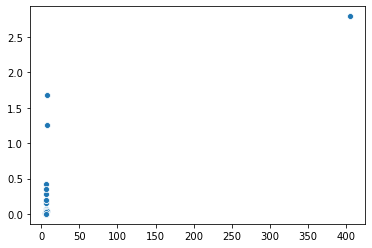

In [54]:
pred=model(x_test,theta)
pred_=pred+sigma_noise*torch.randn_like(pred)
marginal_se_noise=(pred_-y_test)**2
empirical_sqloss_noise=marginal_se_noise.mean(0)
se=(pred_.mean(0)-y_test)**2
sns.scatterplot(empirical_sqloss_noise.squeeze().cpu(),se.squeeze().cpu())

# distance to HMC #

In [48]:
from Metrics import FunSW, FunKL
device='cuda:0'

def projection(theta0,theta1, n_input_samples):
    #batch sample OOD   
    n_ood=n_input_samples
    epsilon=0.1
    x_train_=x_train.to(device)
    M = x_train_.max(0, keepdim=True)[0]+epsilon
    m = x_train_.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=X_ood

    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj


def _FunKL(s,t,projection,device):
    k=1
    FKL=FunKL(s,t,projection=projection,device=device,k=k)
    while torch.isinf(FKL):
        k+=1
        FKL=FunKL(s,t,projection=projection,device=device,k=k)
    return FKL


In [89]:
models_HMC = torch.load('Results/HMC_models.pt')
t=models_HMC[dataset].to(device)
s=GeN(t.shape[0]).detach().to(device)
kl_to=_FunKL(s,t,projection,device)
kl_from=_FunKL(t,s,projection,device)
print('KL(-,HMC): '+str(kl_to.item()))
print('KL(HMC,-): '+str(kl_from.item()))

KL(-,HMC): 28.79901123046875
KL(HMC,-): 114.59158325195312


# grid search #


In [60]:
from Inference.IVI import IVI


def meanlogKNNdistance(sample,k):
    distances= torch.cdist(sample, sample, p=2)
    kNN = torch.topk(distances, k=k + 1, dim=1, largest=False, sorted=True)[0][:,k]  # .clamp(torch.finfo().eps,float('inf
    return kNN.log().mean()

def kl(x_data, GeN,beta):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device, beta=beta)
    return K

def run(sigma_noise):
    beta=1. #TO DO
    alpha=(batch_size/size_data)

    def ELBO(x_data, y_data, GeN):
        Average_LogLikelihood=loss(x_data, y_data, GeN, sigma_noise)
        the_KL=kl(x_data, GeN, beta)
        the_ELBO= - Average_LogLikelihood+ alpha* the_KL#(len(x_data)/size_data)*the_KL
        return the_ELBO, the_KL, Average_LogLikelihood 
    GeN = BigGenerator(lat_dim,param_count,device).to(device)
    optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)
    Run=IVI(train_loader, ELBO, optimizer)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=False, min_lr=min_lr)
    
    for t in range(n_epochs):
        scores=Run.run(GeN)
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break

    theta=GeN(2000).detach()
    metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu', std=False)
    meanNNs=[]
    for (x,y) in train_loader:
        sample=GeN(n_samples_KL)
        pred,_=projection(sample,sample,x)
        #meanNNs.append(meanlogKNNdistance(pred,k=1).item())
    metrics.update({'sigma':sigma_noise,'beta':beta, 'alpha':alpha})
    print(metrics)
    return metrics 


In [77]:
betas=torch.linspace(0.1,1.1,10).numpy()
sigmas=torch.linspace(0.1, 1.,10).numpy()
gs_results=[]
nb_restart=5
for i in trange(len(sigmas)):
    print(sigmas[i])
    for j in range(nb_restart):
        print('{}/{}'.format(j+1,nb_restart))
        gs_results.append(run(sigmas[i]))

    



  0%|          | 0/10 [00:00<?, ?it/s]

0.1
1/5
{'RMSE': 0.7251188158988953, 'LPP': 1.269240379333496, 'PICP': 0.9677419066429138, 'MPIW': 0.9905608892440796, 'sigma': 0.1, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 0.7254322171211243, 'LPP': 1.2688814401626587, 'PICP': 0.9677419066429138, 'MPIW': 0.7822405695915222, 'sigma': 0.1, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 0.7033997774124146, 'LPP': 1.2883952856063843, 'PICP': 0.9677419066429138, 'MPIW': 0.7316223382949829, 'sigma': 0.1, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 0.61553955078125, 'LPP': 1.3040271997451782, 'PICP': 1.0, 'MPIW': 0.7303999066352844, 'sigma': 0.1, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 10%|█         | 1/10 [04:16<38:24, 256.09s/it]

{'RMSE': 0.6858827471733093, 'LPP': 1.2857849597930908, 'PICP': 0.9677419066429138, 'MPIW': 0.6461488604545593, 'sigma': 0.1, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.19999999
1/5
{'RMSE': 0.7460259795188904, 'LPP': 0.657508373260498, 'PICP': 1.0, 'MPIW': 0.9836503267288208, 'sigma': 0.19999999, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 0.6791019439697266, 'LPP': 0.6634635925292969, 'PICP': 1.0, 'MPIW': 0.9151089191436768, 'sigma': 0.19999999, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 0.6696189641952515, 'LPP': 0.6648455858230591, 'PICP': 1.0, 'MPIW': 0.8112852573394775, 'sigma': 0.19999999, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 0.8258846402168274, 'LPP': 0.6529793739318848, 'PICP': 1.0, 'MPIW': 0.8601195216178894, 'sigma': 0.19999999, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 20%|██        | 2/10 [07:24<31:26, 235.82s/it]

{'RMSE': 0.5230047106742859, 'LPP': 0.6731303930282593, 'PICP': 1.0, 'MPIW': 0.8803861141204834, 'sigma': 0.19999999, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.29999998
1/5
{'RMSE': 0.8436911106109619, 'LPP': 0.2665012776851654, 'PICP': 1.0, 'MPIW': 1.0564407110214233, 'sigma': 0.29999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 0.6799319386482239, 'LPP': 0.27191275358200073, 'PICP': 1.0, 'MPIW': 1.1571364402770996, 'sigma': 0.29999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 0.6041886806488037, 'LPP': 0.27486148476600647, 'PICP': 1.0, 'MPIW': 1.0042335987091064, 'sigma': 0.29999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 0.7902928590774536, 'LPP': 0.26842811703681946, 'PICP': 1.0, 'MPIW': 1.0562347173690796, 'sigma': 0.29999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 30%|███       | 3/10 [10:19<25:22, 217.48s/it]

{'RMSE': 0.7337493300437927, 'LPP': 0.27106595039367676, 'PICP': 1.0, 'MPIW': 0.9907324910163879, 'sigma': 0.29999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.39999998
1/5
{'RMSE': 0.6849270462989807, 'LPP': -0.01087620947510004, 'PICP': 1.0, 'MPIW': 1.3927332162857056, 'sigma': 0.39999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 0.6833941340446472, 'LPP': -0.010325524024665356, 'PICP': 1.0, 'MPIW': 1.2117747068405151, 'sigma': 0.39999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 0.6478231549263, 'LPP': -0.009836796671152115, 'PICP': 1.0, 'MPIW': 1.2220591306686401, 'sigma': 0.39999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 0.7165968418121338, 'LPP': -0.010854475200176239, 'PICP': 1.0, 'MPIW': 1.182848572731018, 'sigma': 0.39999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 40%|████      | 4/10 [13:32<21:00, 210.13s/it]

{'RMSE': 0.5092493891716003, 'LPP': -0.007483774796128273, 'PICP': 1.0, 'MPIW': 1.1007992029190063, 'sigma': 0.39999998, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.49999997
1/5
{'RMSE': 0.4995485246181488, 'LPP': -0.2291727066040039, 'PICP': 1.0, 'MPIW': 1.2856467962265015, 'sigma': 0.49999997, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 0.9615480303764343, 'LPP': -0.23437976837158203, 'PICP': 1.0, 'MPIW': 1.1506308317184448, 'sigma': 0.49999997, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 0.7014604210853577, 'LPP': -0.23120930790901184, 'PICP': 1.0, 'MPIW': 1.1928027868270874, 'sigma': 0.49999997, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 0.935693085193634, 'LPP': -0.23418010771274567, 'PICP': 1.0, 'MPIW': 1.1351888179779053, 'sigma': 0.49999997, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 50%|█████     | 5/10 [17:07<17:38, 211.70s/it]

{'RMSE': 0.8666832447052002, 'LPP': -0.23292289674282074, 'PICP': 1.0, 'MPIW': 1.134625792503357, 'sigma': 0.49999997, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.6
1/5
{'RMSE': 0.6112826466560364, 'LPP': -0.4111810028553009, 'PICP': 1.0, 'MPIW': 1.2843753099441528, 'sigma': 0.6, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 0.6260736584663391, 'LPP': -0.41174671053886414, 'PICP': 1.0, 'MPIW': 1.5463675260543823, 'sigma': 0.6, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 1.047231674194336, 'LPP': -0.4152376651763916, 'PICP': 1.0, 'MPIW': 1.310327410697937, 'sigma': 0.6, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 0.6931661367416382, 'LPP': -0.4120674729347229, 'PICP': 1.0, 'MPIW': 1.4253084659576416, 'sigma': 0.6, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 60%|██████    | 6/10 [21:13<14:47, 221.81s/it]

{'RMSE': 0.8632373213768005, 'LPP': -0.4131736159324646, 'PICP': 1.0, 'MPIW': 1.231211543083191, 'sigma': 0.6, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.70000005
1/5
{'RMSE': 0.9446186423301697, 'LPP': -0.5666067004203796, 'PICP': 1.0, 'MPIW': 1.1839100122451782, 'sigma': 0.70000005, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 1.0691843032836914, 'LPP': -0.5677584409713745, 'PICP': 1.0, 'MPIW': 1.3994183540344238, 'sigma': 0.70000005, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 1.2339940071105957, 'LPP': -0.5693530440330505, 'PICP': 1.0, 'MPIW': 1.263466477394104, 'sigma': 0.70000005, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 1.2309684753417969, 'LPP': -0.5694085955619812, 'PICP': 1.0, 'MPIW': 1.3067370653152466, 'sigma': 0.70000005, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 70%|███████   | 7/10 [26:23<12:25, 248.50s/it]

{'RMSE': 1.2602837085723877, 'LPP': -0.5695337653160095, 'PICP': 1.0, 'MPIW': 1.2026773691177368, 'sigma': 0.70000005, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.8
1/5
{'RMSE': 0.7070707678794861, 'LPP': -0.6981284618377686, 'PICP': 1.0, 'MPIW': 1.5767743587493896, 'sigma': 0.8, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 1.089855670928955, 'LPP': -0.7001533508300781, 'PICP': 1.0, 'MPIW': 1.168128252029419, 'sigma': 0.8, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 0.8966290950775146, 'LPP': -0.6990665793418884, 'PICP': 1.0, 'MPIW': 1.5469821691513062, 'sigma': 0.8, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 1.017150640487671, 'LPP': -0.6996855735778809, 'PICP': 1.0, 'MPIW': 1.3415087461471558, 'sigma': 0.8, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 80%|████████  | 8/10 [31:32<08:53, 266.56s/it]

{'RMSE': 1.0811625719070435, 'LPP': -0.7005407214164734, 'PICP': 1.0, 'MPIW': 1.7862480878829956, 'sigma': 0.8, 'beta': 1.0, 'alpha': 0.10830324909747292}
0.9
1/5
{'RMSE': 1.0584295988082886, 'LPP': -0.8169683218002319, 'PICP': 1.0, 'MPIW': 1.3677256107330322, 'sigma': 0.9, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 1.3327240943908691, 'LPP': -0.8186266422271729, 'PICP': 1.0, 'MPIW': 1.4478299617767334, 'sigma': 0.9, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 1.286260962486267, 'LPP': -0.8186153173446655, 'PICP': 1.0, 'MPIW': 1.6522669792175293, 'sigma': 0.9, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 0.9683138132095337, 'LPP': -0.8163573741912842, 'PICP': 1.0, 'MPIW': 1.1796084642410278, 'sigma': 0.9, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


 90%|█████████ | 9/10 [36:46<04:40, 280.72s/it]

{'RMSE': 1.532961368560791, 'LPP': -0.8204337954521179, 'PICP': 1.0, 'MPIW': 1.829298734664917, 'sigma': 0.9, 'beta': 1.0, 'alpha': 0.10830324909747292}
1.0
1/5
{'RMSE': 1.0709893703460693, 'LPP': -0.9218882322311401, 'PICP': 1.0, 'MPIW': 1.5558704137802124, 'sigma': 1.0, 'beta': 1.0, 'alpha': 0.10830324909747292}
2/5
{'RMSE': 0.989934504032135, 'LPP': -0.92155921459198, 'PICP': 1.0, 'MPIW': 1.547324299812317, 'sigma': 1.0, 'beta': 1.0, 'alpha': 0.10830324909747292}
3/5
{'RMSE': 1.2104007005691528, 'LPP': -0.922346293926239, 'PICP': 1.0, 'MPIW': 1.3477227687835693, 'sigma': 1.0, 'beta': 1.0, 'alpha': 0.10830324909747292}
4/5
{'RMSE': 1.4000054597854614, 'LPP': -0.9234217405319214, 'PICP': 1.0, 'MPIW': 1.4003928899765015, 'sigma': 1.0, 'beta': 1.0, 'alpha': 0.10830324909747292}
5/5


100%|██████████| 10/10 [41:09<00:00, 246.95s/it]

{'RMSE': 1.226105809211731, 'LPP': -0.9224520325660706, 'PICP': 1.0, 'MPIW': 1.4573791027069092, 'sigma': 1.0, 'beta': 1.0, 'alpha': 0.10830324909747292}


In [101]:
import pandas as pd
#gs_results=torch.load('Results/GridSearchSigma_Yacht2020-08-31-18:19.pt')
#gs_results=torch.load('Results/GridSearchSigma_Yacht2020-09-01-10:59.pt')
#gs_results=torch.load('Results/GridSearchSigma_Yacht2020-09-01-13:25.pt')
#gs_results=torch.load('Results/GridSearchSigma_Yacht2020-09-02-10:39.pt')
#gs_results=torch.load('Results/GridSearchSigma_Yacht2020-09-02-13:51.pt')
gs_results=torch.load('Results/GridSearchSigma_boston_2020-09-03-15:50.pt')#+torch.load('Results/GridSearchSigma_boston_2020-09-03-17:25.pt')+torch.load('Results/GridSearchSigma_boston_2020-09-03-15:50.pt')+torch.load('Results/GridSearchSigma_boston_2020-09-03-15:36.pt')


results=pd.DataFrame(gs_results)
#results=results.drop(index=results.index[[1]])
results

,RMSE,LPP,PICP,MPIW,sigma,beta,alpha,test risk w/ noise,ELBO
0,3.418281,-4.460558,0.470588,1.572864,0.100000,1.0,1.0,0.176626,-14.607164
1,2.953134,-0.382672,1.000000,13.003986,0.422222,1.0,1.0,4.557591,16.225245
2,3.125601,-0.751505,1.000000,16.020641,0.744444,1.0,1.0,6.675637,31.874536
3,3.752451,-1.074907,1.000000,23.784082,1.066667,1.0,1.0,20.269613,53.092369
4,4.440147,-1.315077,1.000000,19.689426,1.388889,1.0,1.0,11.971338,67.403659
5,2.446821,-1.505533,1.000000,19.593927,1.711111,1.0,1.0,14.776843,68.648894
6,2.840925,-1.663074,1.000000,14.433620,2.033333,1.0,1.0,8.936569,77.856643
7,2.285615,-1.794534,1.000000,13.338580,2.355556,1.0,1.0,9.775729,84.310945
8,2.574523,-1.925345,1.000000,15.803824,2.677778,1.0,1.0,12.148847,90.017808
9,4.042086,-2.045770,1.000000,15.627895,3.000000,1.0,1.0,13.948996,95.956888


<Figure size 720x720 with 0 Axes>

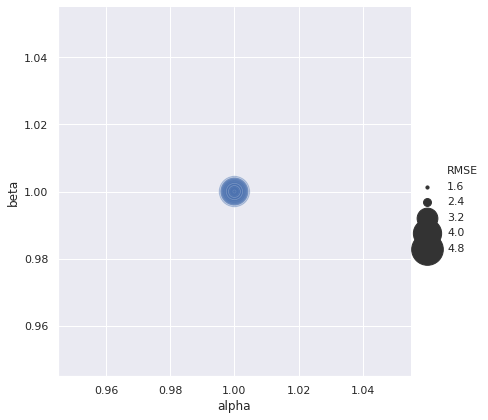

In [102]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.relplot(x="alpha", y="beta", size="RMSE",
            sizes=(10, 1000), alpha=.5, palette="muted",
            height=6, data=results)
#results['RMSE']

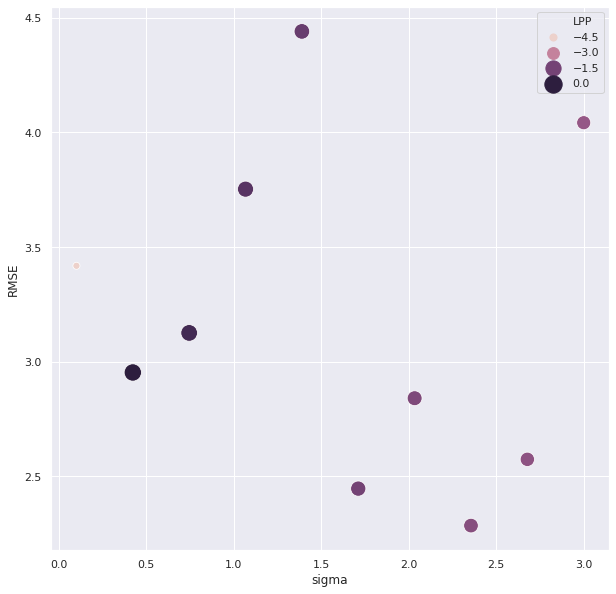

In [103]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax=sns.scatterplot('sigma','RMSE',hue='LPP',size='LPP', data=results,ci=None,sizes=(50, 300))
#ax=sns.pointplot('sigma','LPP', data=results,ci=None)
#xlabels = np.round(betas,2)
#ax.set_xticklabels(xlabels)
#print(results['RMSE'])

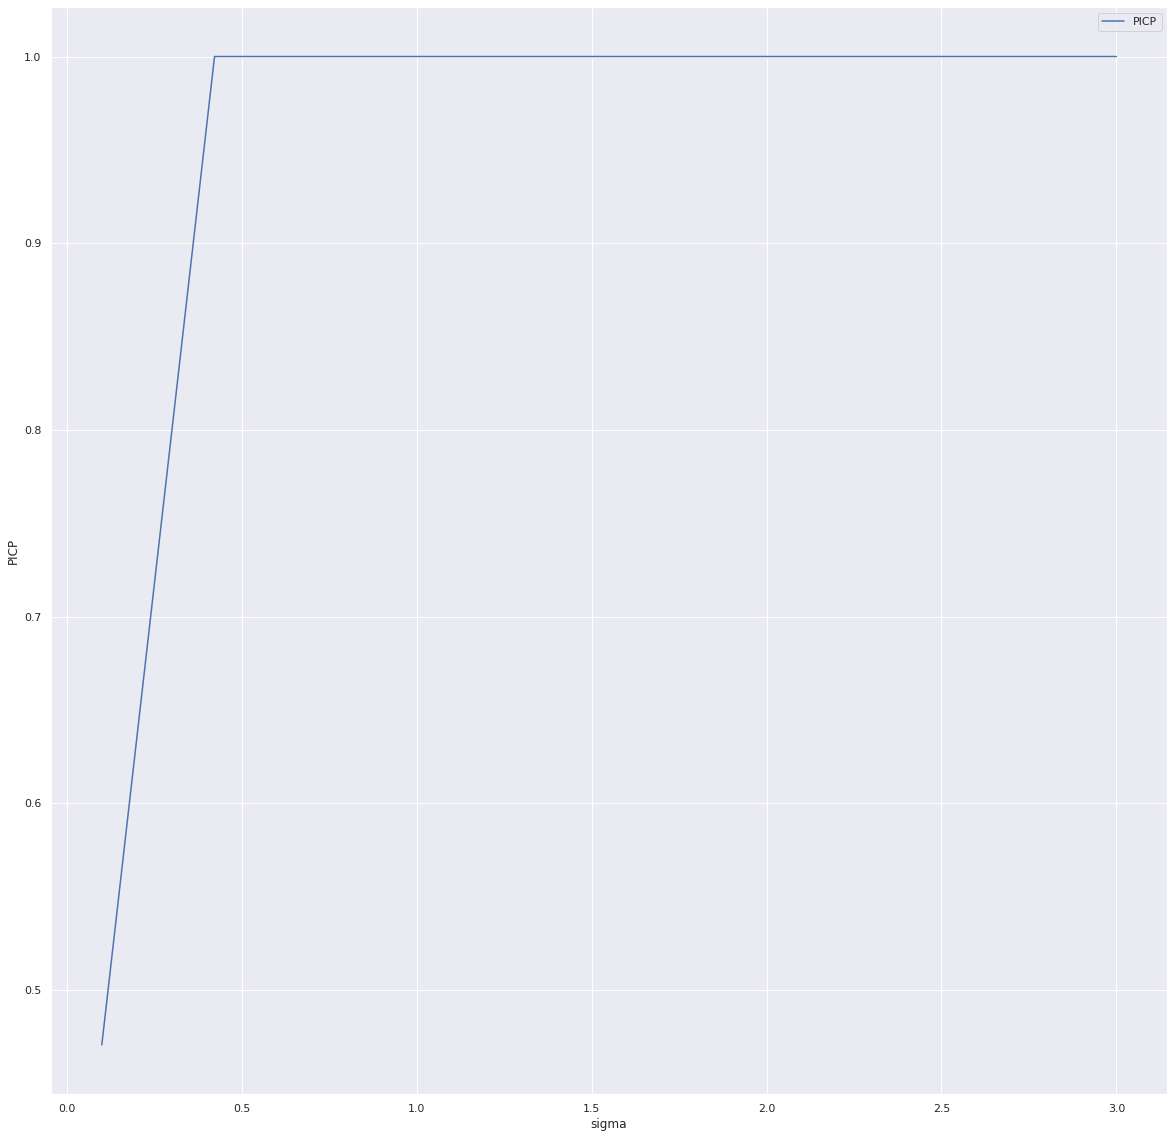

In [104]:
ax=sns.lineplot('sigma','PICP', data=results, label='PICP')


In [105]:
ax=sns.lineplot('sigma',results['test risk'], data=results)

ax=sns.lineplot('sigma',results['test risk w/ noise'], data=results)


KeyError: 'test risk'

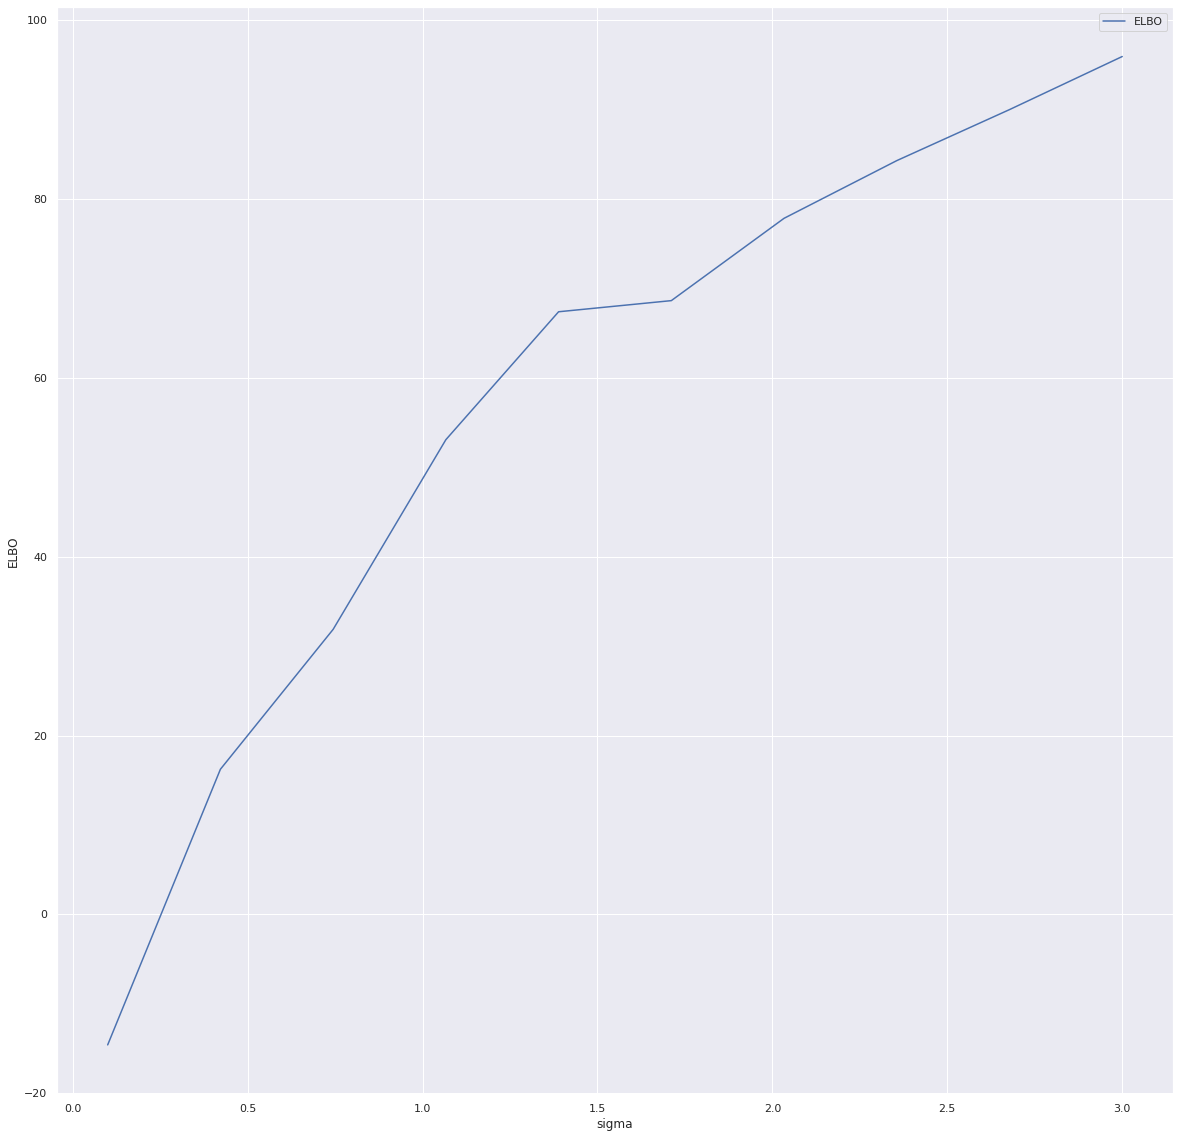

In [106]:
ax=sns.lineplot('sigma','ELBO', data=results, label='ELBO')
#ax=sns.lineplot('sigma','LPP', data=results,label='LPP')



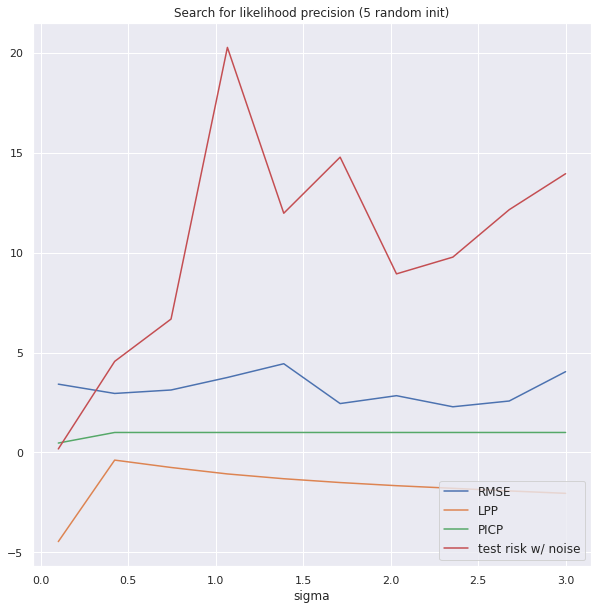

In [107]:
plt.figure(figsize=(10,10))

ax=sns.lineplot('sigma','RMSE', data=results, label='RMSE')
ax=sns.lineplot('sigma','LPP', data=results,label='LPP')
ax=sns.lineplot('sigma','PICP', data=results, label='PICP')
#ax=sns.lineplot('sigma','MPIW', data=results, label='MPIW')

#ax=sns.lineplot('sigma','test risk', data=results, label='test risk')
ax=sns.lineplot('sigma','test risk w/ noise', data=results, label='test risk w/ noise')


ax.set_ylabel('')

#xlabels = np.round(betas,2)
#ax.set_xticklabels(xlabels)
plt.title('Search for likelihood precision (5 random init)')
plt.legend()
ax.legend(loc='lower right', fontsize=12)


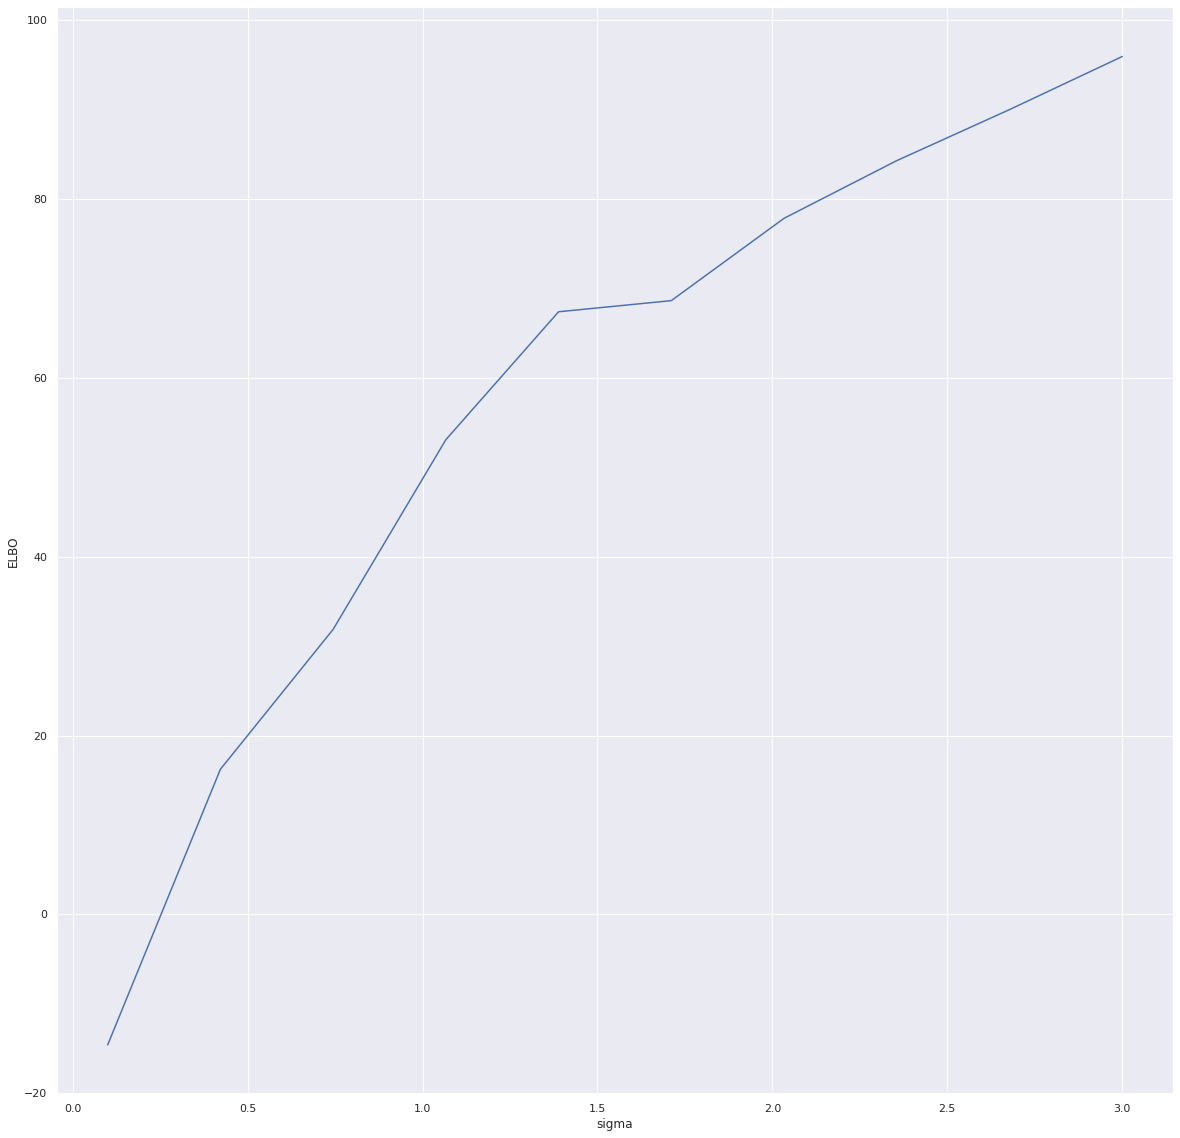

In [108]:
ax=sns.lineplot('sigma','ELBO', data=results)
